In [1]:
###     Imports             - Public Libraries
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import multiprocessing as mp

from copy import deepcopy
from datetime import datetime
from tqdm import tqdm
from time import time
from statistics import mean, stdev
from math import comb

###     Imports             - User-Defined Files
from generic_agent import GenericAgent as Agent
from iam_models import distance

###     Results Dictionary Creation
results_dict = {}

## Simulation Function

In [2]:
"""         IMPORTANT PARAMETERS        """

###     Initializations     - Scalars
dim             =   3   # 2 or 3
num_agents      =   20
num_faulty      =   6   # must be << num_agents for sparse error assumption
n_scp           =   12  # Number of SCP iterations
n_admm          =   10  # Number of ADMM iterations
n_iter          =   n_admm * n_scp
use_threshold   =   False
iam_noise       =   0.02
pos_noise       =   0.02


###     Initializations     - Thresholds
dual_var_check  =   True
R_diff_check    =   False
lam_thresh      =   1.5
mu_thresh       =   5e-3
R_diff_thresh   =   0.8


###     Initializations     - Simulation Variable Parameters
rho_opt = [0.25, 0.75]
warm_start_opt = [True, False]


###     Initializations     - Output Settings
show_prints     =   True
hide_tqdm       =   False
show_prob1      =   False
show_prob2      =   False


###     Initializations     - Agents
# 20 agents making up a complex 3d configuration
agents      =   [None] * num_agents
agents[0]   =   Agent(agent_id = 0, init_position = np.array([[0.1, 2.4, 5.4]]).T)
agents[1]   =   Agent(agent_id = 1, init_position = np.array([[2.8, 5.4, 6.1]]).T)
agents[2]   =   Agent(agent_id = 2, init_position = np.array([[2.15, 4.8, 4.3]]).T)
agents[3]   =   Agent(agent_id = 3, init_position = np.array([[1.15, 0.4, 3.9]]).T)
agents[4]   =   Agent(agent_id = 4, init_position = np.array([[3.0, 3.85, 5.4]]).T)
agents[5]   =   Agent(agent_id = 5, init_position = np.array([[3.4, 4.25, 2.0]]).T)
agents[6]   =   Agent(agent_id = 6, init_position = np.array([[3.45, 1.8, 2.2]]).T)
agents[7]   =   Agent(agent_id = 7, init_position = np.array([[5.2, 5.0, 5.25]]).T)
agents[8]   =   Agent(agent_id = 8, init_position = np.array([[5.3, 3.8, 0.1]]).T)
agents[9]   =   Agent(agent_id = 9, init_position = np.array([[5.2, 0.8, 3.15]]).T)
agents[10]  =   Agent(agent_id = 10, init_position = np.array([[6.2, 3.3, 5.6]]).T)
agents[11]  =   Agent(agent_id = 11, init_position = np.array([[5.05, 3.8, 3.6]]).T)
agents[12]  =   Agent(agent_id = 12, init_position = np.array([[4.15, 5.65, 3.4]]).T)
agents[13]  =   Agent(agent_id = 13, init_position = np.array([[0.15, 3.4, 2.45]]).T)
agents[14]  =   Agent(agent_id = 14, init_position = np.array([[1.85, 5.15, 0.65]]).T)
agents[15]  =   Agent(agent_id = 15, init_position = np.array([[2.4, 2.4, 1.6]]).T)
agents[16]  =   Agent(agent_id = 16, init_position = np.array([[1.4, 5.4, 2.4]]).T)
agents[17]  =   Agent(agent_id = 17, init_position = np.array([[3.2, 3.4, 0.2]]).T)
agents[18]  =   Agent(agent_id = 18, init_position = np.array([[5.4, 5.4, 1.4]]).T)
agents[19]  =   Agent(agent_id = 19, init_position = np.array([[4.7, 2.4, 5.4]]).T)

# Add error vector
faulty_id1  =   [0, 5, 7]
faulty_id2  =   [9, 10, 13]
faulty_id   =   faulty_id1 + faulty_id2

fault_vec1  =   [np.array([[0.275, 0.447, 0.130]]).T,
                np.array([[-0.849, 0.170, 0.888]]).T,
                np.array([[0.761, -0.408, 0.438]]).T]
fault_vec2  =   [np.array([[-0.640, 0.260, -0.941]]).T,
                np.array([[0.879, 0.425, -0.710]]).T,
                np.array([[-0.534, -0.543, -0.588]]).T]
fault_vec = fault_vec1 + fault_vec2

for index, agent_id in enumerate(faulty_id):
    agents[agent_id].error_vector = fault_vec[index][:,np.newaxis].reshape((dim, -1))

x_true = []
for id, agent in enumerate(agents):
    x_true.append(0.0*agent.error_vector)


# Set Neighbors
edges       =  [[0,2], [0,3], [0,4], [0,16], 
                [1,2], [1,4], [1,7], [1,11],
                [2,4], [2,5], [2,7], [3,4],
                [4,5], [4,6], [4,7], [4,10],
                [5,6], [5,8], [6,7], [6,9],
                [7,10], [8,9], [8,11], [9,11],
                [9,10], [10,11], [12,5], [12,7],
                [12,11], [12,2], [13,14], [13,15],
                [14,15], [3,15], [5,15], [13,0],
                [14,5], [6,14], [19,10], [19,4],
                [19,9], [18,8], [18,17], [18,11],
                [18,12], [17,14], [17,15], [17,8],
                [17,18], [16,14], [16,2], [16,13],
                [18,5], [15,6], [16,3], [0,19],
                [7,19], [17,5]] 
edges_flip  =   deepcopy(edges)
for idx, dir_edge in enumerate(edges_flip):
    dir_edge.reverse()

edges       =   edges+edges_flip            # these edges are directed

for agent_id, agent in enumerate(agents):
    # Neighbor List
    nbr_list        =   []
    edge_list       =   []
    
    for edge_ind, edge in enumerate(edges):
        if (agent_id) == edge[0]:
            nbr_list.append(edge[1])
            edge_list.append(edge_ind)
    
    agent.set_neighbors(nbr_list)
    agent.set_edge_indices(edge_list)



###     Useful Functions

# Measurement function Phi
def measurements(p, x_hat):
    measurements = []

    for edge in edges:
        dist = distance((p[edge[0]] + x_hat[edge[0]]), (p[edge[1]] + x_hat[edge[1]]))
        measurements.append(dist)

    return measurements

# Finds row of R
def get_Jacobian_row(edge_ind, p, x):
    edge = edges[edge_ind]
    agent1_id = edge[0]
    agent2_id = edge[1]
    pos1 = p[edge[1]] + x[edge[1]]
    pos2 = p[edge[0]] + x[edge[0]]
    disp    = (pos1 - pos2)
    R_k = np.zeros((1, dim*num_agents))

    dist = distance(pos1, pos2)
    R_k[:, dim*agent2_id:dim*(agent2_id + 1)] = disp.T  / dist
    R_k[:, dim*agent1_id:dim*(agent1_id + 1)] = -disp.T / dist

    return R_k

# Computes whole R matrix
def get_Jacobian_matrix(p, x):
    R = []

    for edge_ind, edge in enumerate(edges):
        R.append(get_Jacobian_row(edge_ind, p, x))
    
    return R

# Returns rank of Jacobian matrix
def get_Jacobian_rank(R):
    
    jac_matrix = R[0]
    for row in R[1:]:
        jac_matrix = np.vstack((jac_matrix, row))
    
    return np.linalg.matrix_rank(jac_matrix)

# Returns the matrix norm of the difference between old and new R matrices
def get_Jacobian_matrix_norm_diff(R_old, R_new):
    
    # Find R_norm_diff for each agent
    R_norm_diff_arr = [0] * num_agents

    for id, _ in enumerate(agents):
        # Get Agent Edge List
        this_edge_list = agents[id].get_edge_indices()
        
        # Construct 2D Array of Old Matrix
        old_matrix = R_old[this_edge_list[0]]
        for edge_ind in this_edge_list[1:]:
            old_matrix = np.vstack((old_matrix, R_old[edge_ind]))
        
        # Construct 2D Array of New Matrix
        new_matrix = R_new[this_edge_list[0]]
        for edge_ind in this_edge_list[1:]:
            new_matrix = np.vstack((new_matrix, R_new[edge_ind]))

        R_norm_diff_arr[id] = np.linalg.norm(new_matrix - old_matrix)

    return R_norm_diff_arr



###         Function

def run_sim(rho, warm_start, results_dict):

    ###     Results Dictionary Handling
    if (rho, warm_start) in results_dict.keys():
        trial_num = len(results_dict[(rho, warm_start)])
    else: 
        results_dict[(rho, warm_start)] = []
        trial_num = 0
    print(f"Starting ({rho}, {warm_start}, {trial_num+1}) ...")



    ###     Initializations     - Measurements and Positions

    # Error
    x_star = [np.zeros((dim, 1)) for i in range(num_agents)]                    # Equivalent to last element in x_history (below)
    x_history = [np.zeros((dim, (n_iter))) for i in range(num_agents)]          # Value of x at each iteration of algorithm
    x_norm_history = [np.zeros((1, (n_iter))) for i in range(num_agents)]       # Norm of difference between x_history and x_true

    # Position
    p_est = [agents[i].get_estimated_pos() for i in range(num_agents)]          # Will be updated as algorithm loops and err vector is reconstructed
    p_hat = deepcopy(p_est)                                                     # Reported positions of agents
    p_true = [agents[i].get_true_pos() for i in range(num_agents)]              # CONSTANT: True pos
    p_hat_history = [np.zeros((dim, n_iter)) for i in range(num_agents)]        # Value of p_hat at each iteration of algorithm

    # Interagent measurement
    y = measurements(p_true, x_star)                                            # CONSTANT: Phi(p_hat + x_hat), true interagent measurement

    # Residuals
    residuals = [np.zeros(n_iter) for i in range(num_agents)]                   # Running residuals of each agent (residual <= 1 is nominal)



    ###      Initializations    - Optimization Parameters

    reset_lam = [False] * num_agents
    reset_mu = [False] * num_agents
    total_iterations = np.arange((n_iter))
    for agent_id, agent in enumerate(agents):
        num_edges       = len(agent.get_edge_indices())
        num_neighbors   = len(agent.get_neighbors())

        # CVX variables
        agent.init_x_cp(cp.Variable((dim, 1)))
        agent.init_w_cp(cp.Variable((dim, 1)), agent.get_neighbors())

        # Parameters
        agent.init_x_bar(np.zeros((dim, 1)))
        agent.init_lam(np.zeros((1, 1)), agent.get_edge_indices())
        agent.init_mu(np.zeros((dim, 1)), agent.get_neighbors())
        agent.init_x_star(np.zeros((dim, 1)), agent.get_neighbors()) # own err is last elem
        agent.init_w(np.zeros((dim, 1)), agent.get_neighbors())



    ###     Initializations     - List Parameters
    if show_prints:
        print("\n~ ~ ~ ~ PARAMETERS ~ ~ ~ ~")
        print("rho:", rho)
        print("Number of agents:", num_agents)
        print("Faulty Agent ID and Vector:")
        for i, id in enumerate(faulty_id):
            print(f"\tID: {id}\t\t Vector: {fault_vec[i].flatten()}")



    ### Store stuff
    lam_norm_history = [np.zeros((len(agents[i].get_edge_indices()), n_iter)) for i in range(num_agents)]
    mu_norm_history = [np.zeros((len(agents[i].get_neighbors()), n_iter)) for i in range(num_agents)]
    R_norm_diff_history = [np.zeros(n_scp) for i in range(num_agents)]
    R_norm_diff = [0] * num_agents
    sum_err_rmse = 0.0
    start_time = time()
    solver_err = False
    maximal_rank = dim*num_agents - comb(dim+1, 2)



    ###     Looping             - SCP Outer Loop
    for outer_i in tqdm(range(n_scp), desc="SCP Loop", leave=False, disable=hide_tqdm):

        # Set p_hat depending on iteration number
        for id, agent in enumerate(agents):
            if (outer_i >= round(n_scp*2/3)) and (id in faulty_id2):
                agent.faulty = True
                x_true[id] = fault_vec[faulty_id.index(id)]
                # print(f"\tAgent {id} - Case 1")
            elif ( (outer_i >= round(n_scp*1/3)) and (outer_i < round(n_scp*2/3)) ) and (id in faulty_id1):
                agent.faulty = True
                x_true[id] = fault_vec[faulty_id.index(id)]
                # print(f"\tAgent {id} - Case 2")
            else:
                agent.faulty = False
                x_true[id] *= 0.
            
            p_hat[id] = agent.get_estimated_pos()
            

        # Noise in Position Estimate
        p_hat_noise = deepcopy(p_hat)
        for i, _ in enumerate(p_hat_noise):
            p_hat_noise[i] = p_hat[i] + np.random.uniform(low=-pos_noise, high=pos_noise, size=(dim, 1))

        # Difference between expected and true measurements
        exp_meas    =   measurements(p_hat_noise, x_star)
        z           =   [(y[i] - meas) for i, meas in enumerate(exp_meas)]

        # Linearized Measurement Model
        R_new = get_Jacobian_matrix(p_hat_noise, x_star)
        if (outer_i > 0):
            R_norm_diff = get_Jacobian_matrix_norm_diff(R, R_new)
        R = R_new

        # Check norm difference between new and old R
        if R_diff_check and (not warm_start):
            for agent_id, agent in enumerate(agents):
                if (R_norm_diff[agent_id] >= R_diff_thresh):
                    agent.init_lam(np.zeros((1, 1)), agent.get_edge_indices())
                    agent.init_mu(np.zeros((dim, 1)), agent.get_neighbors())

        # Check if rank of R is maximal
        jac_rank = get_Jacobian_rank(R)
        if (show_prints and (jac_rank != maximal_rank)):
            print(f"\nMaximal Condition not met @ SCP Iteration {outer_i}")
            print(f"\tExpected: {maximal_rank}; Got: {jac_rank}")

        # Reset extra primal variables for inner loop
        for agent in agents:
            agent.init_w(np.zeros((dim, 1)), agent.get_neighbors())



        ###     Looping             - ADMM Inner Loop
        for inner_i in tqdm(range(n_admm), desc="ADMM Loop", leave=False, disable=hide_tqdm):

            ##      Noise               - Add noise to interagent measurements (and therefore z)
            z_noise = [(z[i] + np.random.uniform(low=-iam_noise, high=iam_noise)) for i, _ in enumerate(z)]


            ##      Minimization        - Primal Variable 1
            for id, agent in enumerate(agents):
                # Thresholding: Summation over edges
                term1 = 0
                for i, edge_ind in enumerate(agent.get_edge_indices()):
                    R_k = R[edge_ind]
                    constr_c = R_k[:, dim*id:dim*(id+1)] @ (-agent.x_star[id]) - z[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c += R_k[:, dim*nbr_id:dim*(nbr_id+1)] @ agent.w[nbr_id]
                    
                    term1 += R_k[:, dim*id:dim*(id+1)].T @ (constr_c + (agent.lam[edge_ind] / rho))

                # Thresholding: Summation over neighbors
                term2 = 0
                for nbr_id in agent.get_neighbors():
                    constr_d = -agent.x_star[id] - agent.w[nbr_id]
                    term2 += constr_d + (agent.mu[nbr_id] / rho)

                # Tresholding: Check threshold
                res = np.linalg.norm(term1 + term2)
                residuals[id][inner_i + outer_i*n_admm] = res
                if use_threshold and ((res*rho) <= 1):
                    agent.x_bar = deepcopy(-agent.x_star[id])
                else:
                # Optimization: Find x_bar if over threshold
                    objective = cp.norm(agent.x_star[id] + agent.x_cp)
                    
                    # Summation for c() constraint
                    for _, edge_ind in enumerate(agent.get_edge_indices()): 
                        constr_c = R[edge_ind][:, dim*id:dim*(id+1)] @ agent.x_cp - z[edge_ind]
                        for nbr_id in agent.get_neighbors():
                            constr_c += R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w[id]
                        
                        objective += ((rho/2)*cp.power(cp.norm(constr_c), 2)
                                        + agent.lam[edge_ind].T @ (constr_c))
                    
                    # Summation for d() constraint
                    for _, nbr_id in enumerate(agent.get_neighbors()): 
                        constr_d = agent.x_cp - agent.w[nbr_id]
                        objective += ((rho/2)*cp.power(cp.norm(constr_d), 2)
                                    + agent.mu[nbr_id].T @ (constr_d))
                        
                    prob1 = cp.Problem(cp.Minimize(objective), [])
                    try:
                        prob1.solve(verbose=show_prob1)
                    except cp.SolverError:
                        solver_err = True
                        break
                    
                    if prob1.status != cp.OPTIMAL:
                        print("\nERROR Problem 1: Optimization problem not solved @ (%d, %d, %d)" % (inner_i, outer_i, id))
                    
                    agent.x_bar = deepcopy(np.array(agent.x_cp.value).reshape((-1, 1)))
                
                # Store: Reconstructed Error
                new_x = deepcopy(agent.x_bar.flatten()) + deepcopy(agent.x_star[id].flatten())
                x_history[id][:, inner_i + outer_i*n_admm] = new_x.flatten()

                # Store: Convergence of Reconstructed Error Vector
                new_x_norm = np.linalg.norm(new_x.flatten() + x_true[id].flatten())
                x_norm_history[id][:, inner_i + outer_i*n_admm] = new_x_norm
                sum_err_rmse += new_x_norm


            ##      Minimization        - Primal Variable 2
            for agent_id, agent in enumerate(agents):
                objective = cp.norm(agent.x_star[agent_id] + agent.x_bar)

                # Summation for c() constraint
                for edge_ind in agent.get_edge_indices(): 
                    constr_c = R[edge_ind][:, dim*agent_id:dim*(agent_id+1)] @ agent.x_bar - z_noise[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c = constr_c + R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w_cp[agent_id]
                    
                    objective += ((rho/2)*cp.power(cp.norm(constr_c), 2)
                                    + agent.lam[edge_ind].T @ (constr_c))
                
                # Summation for d() constraint
                for nbr_id in agent.get_neighbors():
                    constr_d = agent.x_bar - agent.w_cp[nbr_id]
                    objective += ((rho/2)*cp.power(cp.norm(constr_d), 2)
                                + agent.mu[nbr_id].T @ (constr_d))
                    
                prob2 = cp.Problem(cp.Minimize(objective), [])
                try:
                    prob2.solve(verbose=show_prob2)
                except cp.SolverError:
                    solver_err = True
                    break

                if prob2.status != cp.OPTIMAL:
                    print("\nERROR Problem 2: Optimization problem not solved @ (%d, %d, %d)" % (inner_i, outer_i, agent_id))

                for _, nbr_id in enumerate(agent.get_neighbors()):
                    agent.w[nbr_id] = deepcopy(np.array(agent.w_cp[nbr_id].value).reshape((-1, 1)))


            ##      Multipliers         - Update Lagrangian Multipliers of Minimization Problem
            for agent_id, agent in enumerate(agents):
                
                # Summation for c() constraint
                for i, edge_ind in enumerate(agent.get_edge_indices()):
                    constr_c = R[edge_ind][:, dim*agent_id:dim*(agent_id+1)] @ agent.x_bar - z_noise[edge_ind]
                    for nbr_id in agent.get_neighbors():
                        constr_c += R[edge_ind][:, dim*nbr_id:dim*(nbr_id+1)] @ agents[nbr_id].w[agent_id]
                    
                    new_lam = (agent.lam[edge_ind] + rho * constr_c)
                    agent.lam[edge_ind] = deepcopy(new_lam)
                    lam_norm_history[agent_id][i, (inner_i + outer_i*n_admm)] = np.linalg.norm(deepcopy(new_lam))

                    if (not warm_start) and (np.linalg.norm(new_lam) > lam_thresh):
                        # print(f"RESET LAM: Agent {agent_id} at SCP {outer_i}")
                        reset_lam[agent_id] = True

                # Summation for d() constraint
                for i, nbr_id in enumerate(agent.get_neighbors()):
                    constr_d = agent.x_bar - agent.w[nbr_id]

                    new_mu = (agent.mu[nbr_id] + rho * constr_d)
                    agent.mu[nbr_id] = deepcopy(new_mu)
                    mu_norm_history[agent_id][i, (inner_i + outer_i*n_admm)] = np.linalg.norm(deepcopy(new_mu))

                    if (not warm_start) and (np.linalg.norm(new_mu) > mu_thresh):
                        # print(f"RESET MU: Agent {agent_id} at SCP {outer_i}")
                        reset_mu[agent_id] = True
                    
            

            ##      Store           - Position and Error Vectors
            for id, agent in enumerate(agents):
                # True Position
                p_hat_history[id][:, inner_i + outer_i*n_admm] = p_hat[id].flatten()

            ##      Check for Solver Error
            if solver_err:
                break


        ###     END Looping         - ADMM Inner Loop

        ##          Check for Solver Error
        if solver_err:
            break
        
        # Update Error Vectors after ADMM subroutine
        for agent_id, agent in enumerate(agents): 
            for list_ind, nbr_id in enumerate(agent.get_neighbors()):
                agent.x_star[nbr_id] = agent.x_star[nbr_id] + agents[nbr_id].x_bar
            
            agent.x_star[agent_id] = agent.x_star[agent_id] + agent.x_bar
            x_star[agent_id] = agent.x_star[agent_id]
            
            # Update position and x_dev
            p_est[agent_id] = p_hat_noise[agent_id] + x_star[agent_id]

            # Store Norm Difference in R for each agent
            R_norm_diff_history[agent_id][outer_i] = R_norm_diff[agent_id]
        
        # Check if a reset flag was set
        if dual_var_check and (not warm_start):
            for agent_id, agent in enumerate(agents):
                if (reset_lam[agent_id] or reset_mu[agent_id]):
                    # print(f"RESET DUAL: Agent {agent_id} at SCP {outer_i}")
                    agent.init_lam(np.zeros((1, 1)), agent.get_edge_indices())
                    agent.init_mu(np.zeros((dim, 1)), agent.get_neighbors())
                    reset_mu[agent_id] = False
                    reset_lam[agent_id] = False


    ###     END Looping         - SCP Outer Loop

    final_time = time()
    if show_prints:
        print("==================================================================================")
        print(f"IAM Noise: {iam_noise}")
        print(f"Position Noise: {pos_noise}")
        print(f"Penalty Parameter: {rho}")
        print(f"Warm Start: {warm_start}")
        print("----------------------------------------------------------------------------------")
        print(f"Average RMSE: {sum_err_rmse / num_agents} m")
        print(f"Elapsed Time: {final_time - start_time} seconds")
        print(f"Average Time per Iteration: {(final_time - start_time)/n_iter} seconds")
        print("==================================================================================")



    ###     Return              - Configure Return Format

    final_iter = 1 + inner_i + outer_i*n_admm
    avg_rmse = sum_err_rmse / (num_agents * final_iter)

    results = {}
    results['solver_err'] = solver_err
    results['avg_rmse'] = avg_rmse
    results['x_norm_history'] = [x_norm_history[i].flatten() for i in range(num_agents)]

    results_dict[(rho, warm_start)].append(results)
    return

---
---

## Simulation: 
###      $\rho = 0.25$
###      Warm Start: TRUE

In [3]:
rho = rho_opt[0]
warm_start = warm_start_opt[0]

run_sim(rho, warm_start, results_dict)

Starting (0.25, True, 1) ...

~ ~ ~ ~ PARAMETERS ~ ~ ~ ~
rho: 0.25
Number of agents: 20
Faulty Agent ID and Vector:
	ID: 0		 Vector: [0.275 0.447 0.13 ]
	ID: 5		 Vector: [-0.849  0.17   0.888]
	ID: 7		 Vector: [ 0.761 -0.408  0.438]
	ID: 9		 Vector: [-0.64   0.26  -0.941]
	ID: 10		 Vector: [ 0.879  0.425 -0.71 ]
	ID: 13		 Vector: [-0.534 -0.543 -0.588]


IAM Noise: 0.02
Position Noise: 0.02
Penalty Parameter: 0.25
Warm Start: True
----------------------------------------------------------------------------------
Average RMSE: 2.5064289041631143 m
Elapsed Time: 158.63382768630981 seconds
Average Time per Iteration: 1.3219485640525819 seconds


---

---

## Simulation: 
###      $\rho = 0.25$
###      Warm Start: FALSE

In [5]:
rho = rho_opt[0]
warm_start = warm_start_opt[1]

run_sim(rho, warm_start, results_dict)

Starting (0.25, False, 1) ...

~ ~ ~ ~ PARAMETERS ~ ~ ~ ~
rho: 0.25
Number of agents: 20
Faulty Agent ID and Vector:
	ID: 0		 Vector: [0. 0. 0.]
	ID: 5		 Vector: [-0.  0.  0.]
	ID: 7		 Vector: [ 0. -0.  0.]
	ID: 9		 Vector: [-0.  0. -0.]
	ID: 10		 Vector: [ 0.  0. -0.]
	ID: 13		 Vector: [-0. -0. -0.]


IAM Noise: 0.02
Position Noise: 0.02
Penalty Parameter: 0.25
Warm Start: False
----------------------------------------------------------------------------------
Average RMSE: 1.5155888697012458e-08 m
Elapsed Time: 161.18591594696045 seconds
Average Time per Iteration: 1.3432159662246703 seconds


---

## Compare:
### $\rho = 0.25$

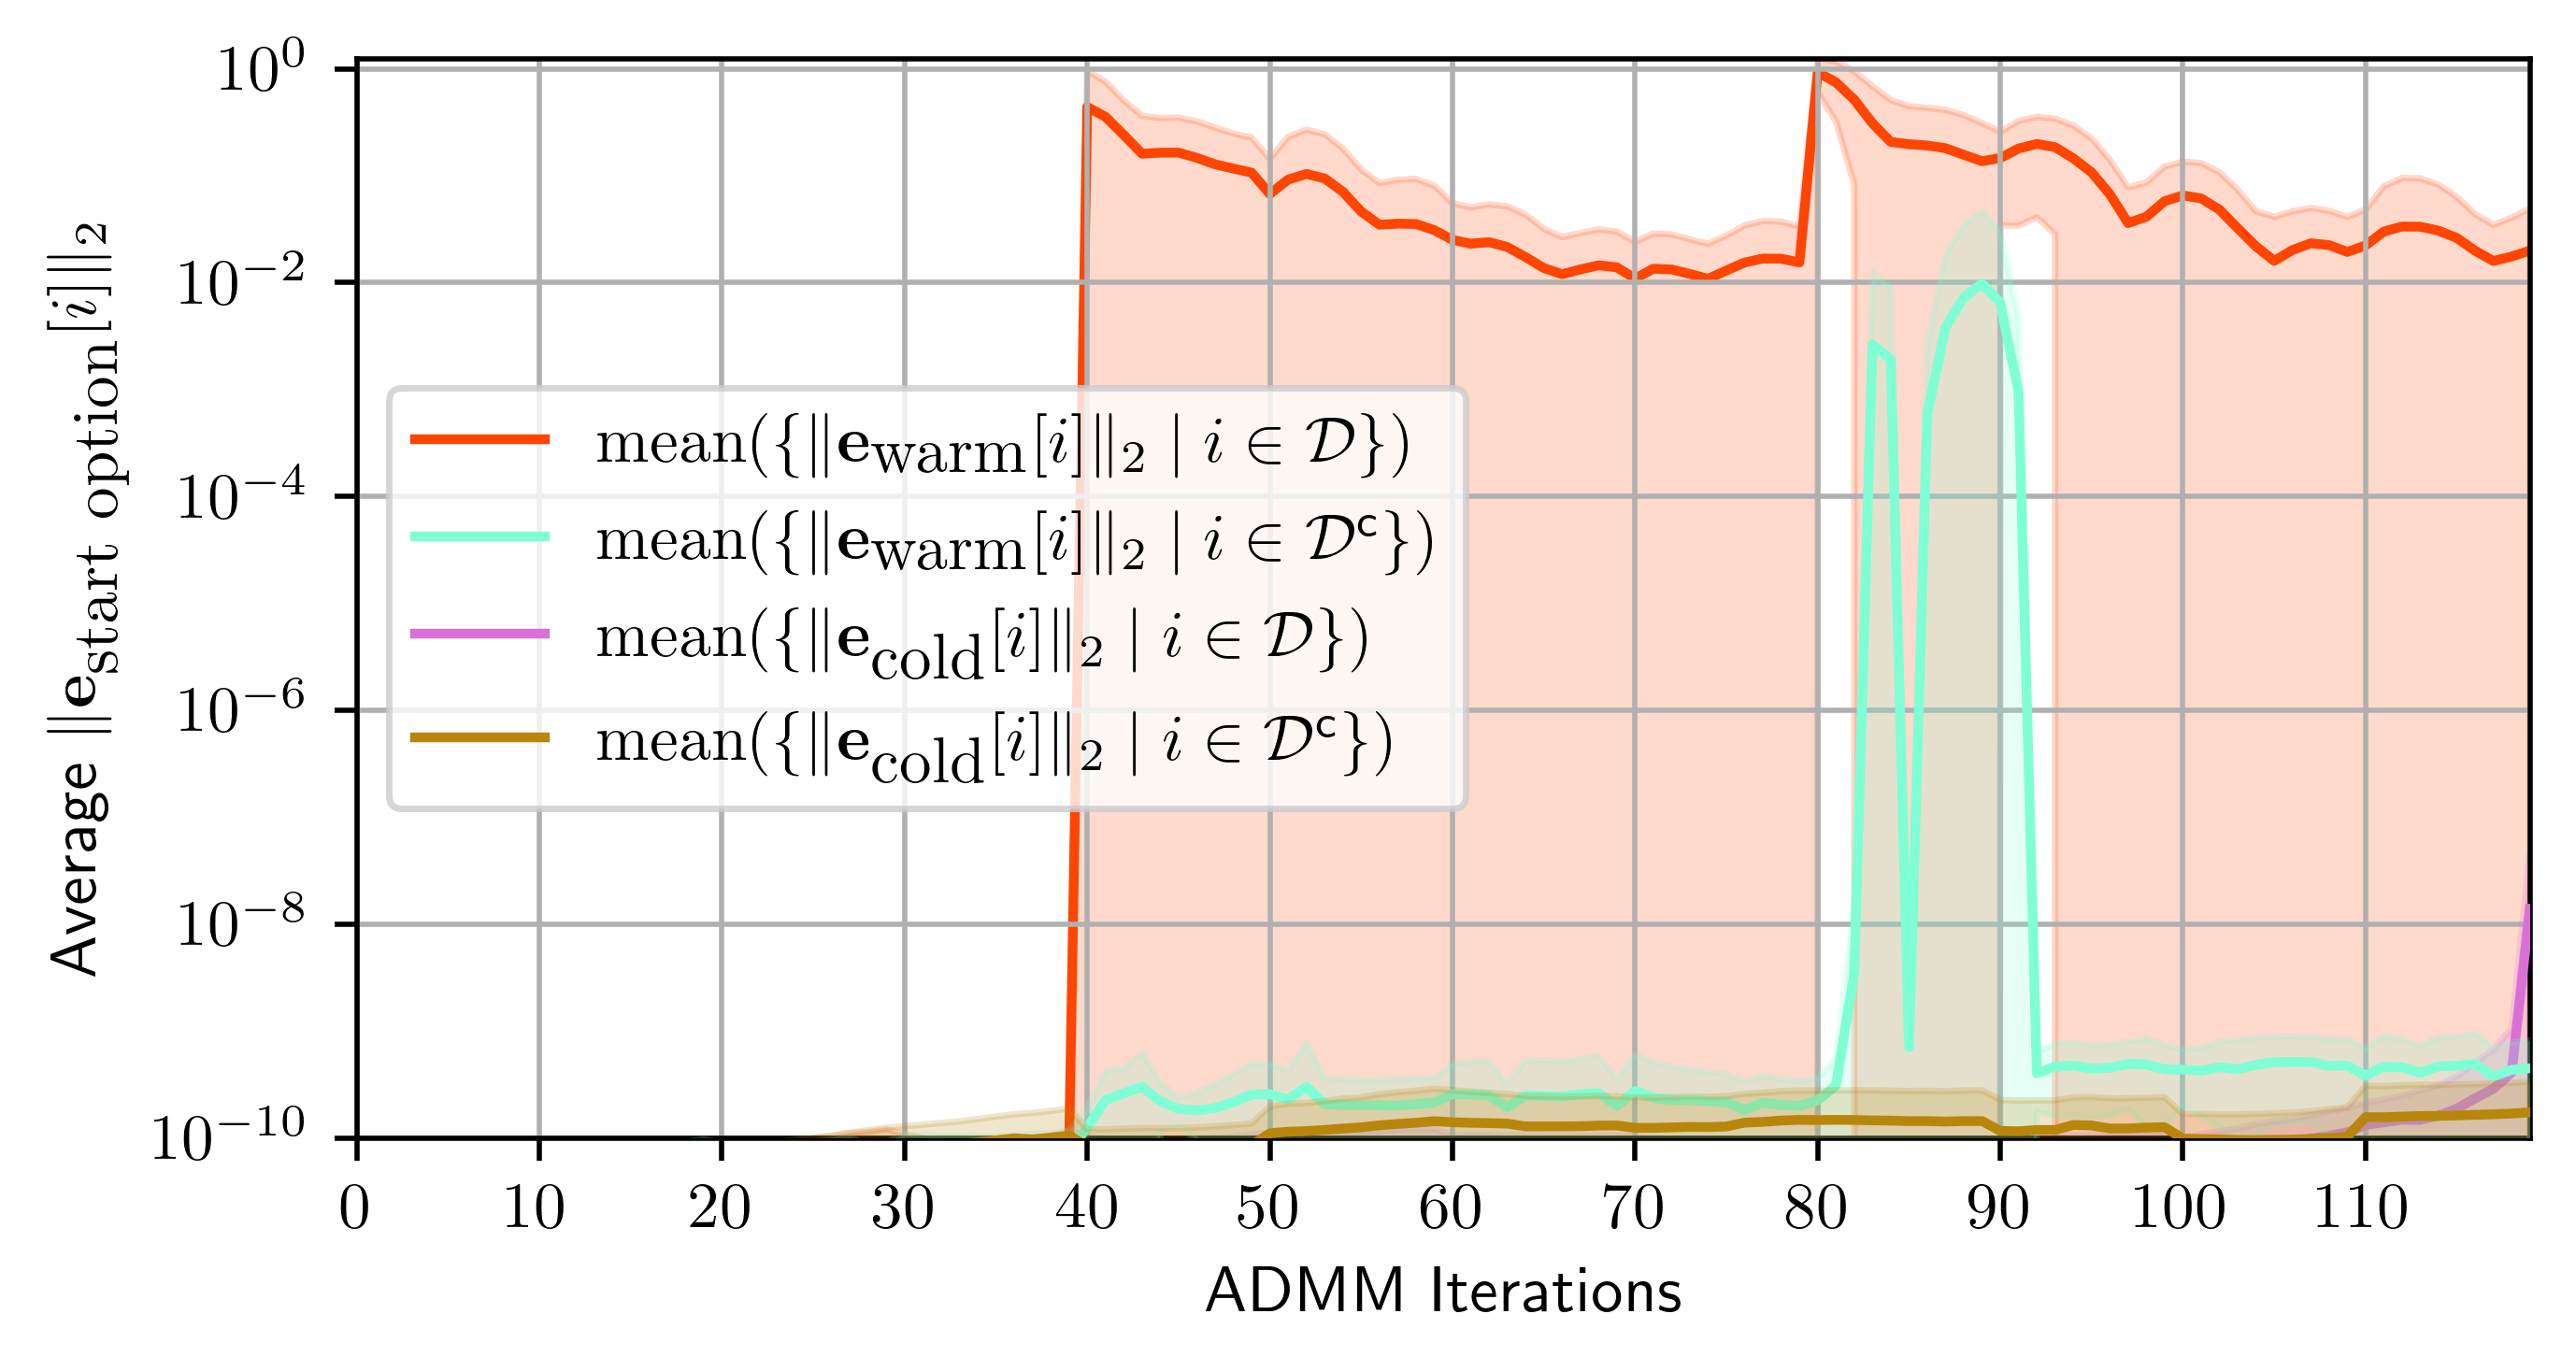

In [15]:
###     Plotting            - Error Convergence

save_err = False
rho = rho_opt[0]
sigma_scale = 1
plt.rcParams.update({
                    'text.usetex': True,
                    })


# Average Agents - WARM START
results_warm = results_dict[(rho, warm_start_opt[0])]
x_norm_warm = results_warm[-1]['x_norm_history']
x_norm_warm = [x_norm_warm[i].flatten() for i in range(num_agents)]
x_norm_warm_nominal = np.zeros((n_iter, 3))
x_norm_warm_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_warm[id][iter])
        else: 
            nominal_vals.append(x_norm_warm[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_warm_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_warm_nominal[iter, 1] = nominal_mean
    x_norm_warm_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_warm_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_warm_faulty[iter, 1] = faulty_mean
    x_norm_warm_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Average Agents - COLD START
results_cold = results_dict[(rho, warm_start_opt[1])]
x_norm_cold = results_cold[-1]['x_norm_history']
x_norm_cold = [x_norm_cold[i].flatten() for i in range(num_agents)]
x_norm_cold_nominal = np.zeros((n_iter, 3))
x_norm_cold_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_cold[id][iter])
        else: 
            nominal_vals.append(x_norm_cold[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_cold_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_cold_nominal[iter, 1] = nominal_mean
    x_norm_cold_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_cold_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_cold_faulty[iter, 1] = faulty_mean
    x_norm_cold_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Create Figure
fig_err1 = plt.figure(dpi=500, figsize=(6,3))
ax_err1 = fig_err1.add_subplot()
lines = [None] * 4
areas = [None] * 4


# Warm Start, Faulty
ax_err1.fill_between(np.arange(n_iter), x_norm_warm_faulty[:, 0], x_norm_warm_faulty[:, 2],
                    alpha=0.2, color='orangered', zorder=0)
lines[0] = ax_err1.plot(np.arange(n_iter), x_norm_warm_faulty[:, 1],
                       c='orangered', zorder=1,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{warm}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Warm Start, Nominal
ax_err1.fill_between(np.arange(n_iter), x_norm_warm_nominal[:, 0], x_norm_warm_nominal[:, 2],
                    alpha=0.2, color='aquamarine', zorder=5)
lines[1] = ax_err1.plot(np.arange(n_iter), x_norm_warm_nominal[:, 1],
                       c='aquamarine', zorder=4, 
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{warm}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')

# Cold Start, Faulty
ax_err1.fill_between(np.arange(n_iter), x_norm_cold_faulty[:, 0], x_norm_cold_faulty[:, 2],
                    alpha=0.2, color='orchid', zorder=2)
lines[2] = ax_err1.plot(np.arange(n_iter), x_norm_cold_faulty[:, 1],
                       c='orchid', zorder=3,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{cold}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Cold Start, Nominal
ax_err1.fill_between(np.arange(n_iter), x_norm_cold_nominal[:, 0], x_norm_cold_nominal[:, 2],
                    alpha=0.2, color='darkgoldenrod', zorder=7)
lines[3] = ax_err1.plot(np.arange(n_iter), x_norm_cold_nominal[:, 1],
                       c='darkgoldenrod', zorder=6,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{cold}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')


# Figure Settings
ax_err1.set_xlabel(r'ADMM Iterations', fontsize=16)
ax_err1.set_ylabel(r'Average $\| \mathbf{e}_\textnormal{start option}[i] \|_2 $', fontsize=16)
# ax_err1.set_ylabel(r'$ \| \mathbf{x}[i] - ( \mathbf{x}^* [i] + \hat{\mathbf{x}}[i]) \| $')
ax_err1.set_ylim((1e-10, 1.25))
ax_err1.set_xlim((0, (n_iter - 1)))
ax_err1.set_xticks(ticks=np.arange(0, n_iter, n_admm))
# ax_err1.set_yticks(ticks=np.arange(0, 1.25, 0.25))
ax_err1.set_yscale('log')
ax_err1.legend(fontsize=16)
ax_err1.grid(True)


# Save Figure
dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
fname_err = "final_fig/discrete/low/compare_err_conv-low_noise-" + dt_string + ".svg"
if save_err:
    plt.savefig(fname_err, dpi=500)

---
---

## Simulation: 
###      $\rho = 0.75$
###      Warm Start: TRUE

In [ ]:
rho = rho_opt[1]
warm_start = warm_start_opt[0]

run_sim(rho, warm_start, results_dict)

Starting (0.75, True, 2) ...

~ ~ ~ ~ PARAMETERS ~ ~ ~ ~
rho: 0.75
Number of agents: 20
Faulty Agent ID and Vector:
	ID: 0		 Vector: [0. 0. 0.]
	ID: 5		 Vector: [-0.  0.  0.]
	ID: 7		 Vector: [ 0. -0.  0.]
	ID: 9		 Vector: [-0.  0. -0.]
	ID: 10		 Vector: [ 0.  0. -0.]
	ID: 13		 Vector: [-0. -0. -0.]


IAM Noise: 0.02
Position Noise: 0.02
Penalty Parameter: 0.75
Warm Start: True
----------------------------------------------------------------------------------
Average RMSE: 0.18617433275480608 m
Elapsed Time: 160.7788758277893 seconds
Average Time per Iteration: 1.3398239652315775 seconds


---


## Simulation: 
###      $\rho = 0.75$
###      Warm Start: FALSE

In [18]:
rho = rho_opt[1]
warm_start = warm_start_opt[1]

run_sim(rho, warm_start, results_dict)

Starting (0.75, False, 2) ...

~ ~ ~ ~ PARAMETERS ~ ~ ~ ~
rho: 0.75
Number of agents: 20
Faulty Agent ID and Vector:
	ID: 0		 Vector: [0. 0. 0.]
	ID: 5		 Vector: [-0.  0.  0.]
	ID: 7		 Vector: [ 0. -0.  0.]
	ID: 9		 Vector: [-0.  0. -0.]
	ID: 10		 Vector: [ 0.  0. -0.]
	ID: 13		 Vector: [-0. -0. -0.]


IAM Noise: 0.02
Position Noise: 0.02
Penalty Parameter: 0.75
Warm Start: False
----------------------------------------------------------------------------------
Average RMSE: 0.17840268371093143 m
Elapsed Time: 161.0971703529358 seconds
Average Time per Iteration: 1.3424764196077983 seconds


---

## Compare:
### $\rho = 0.75$

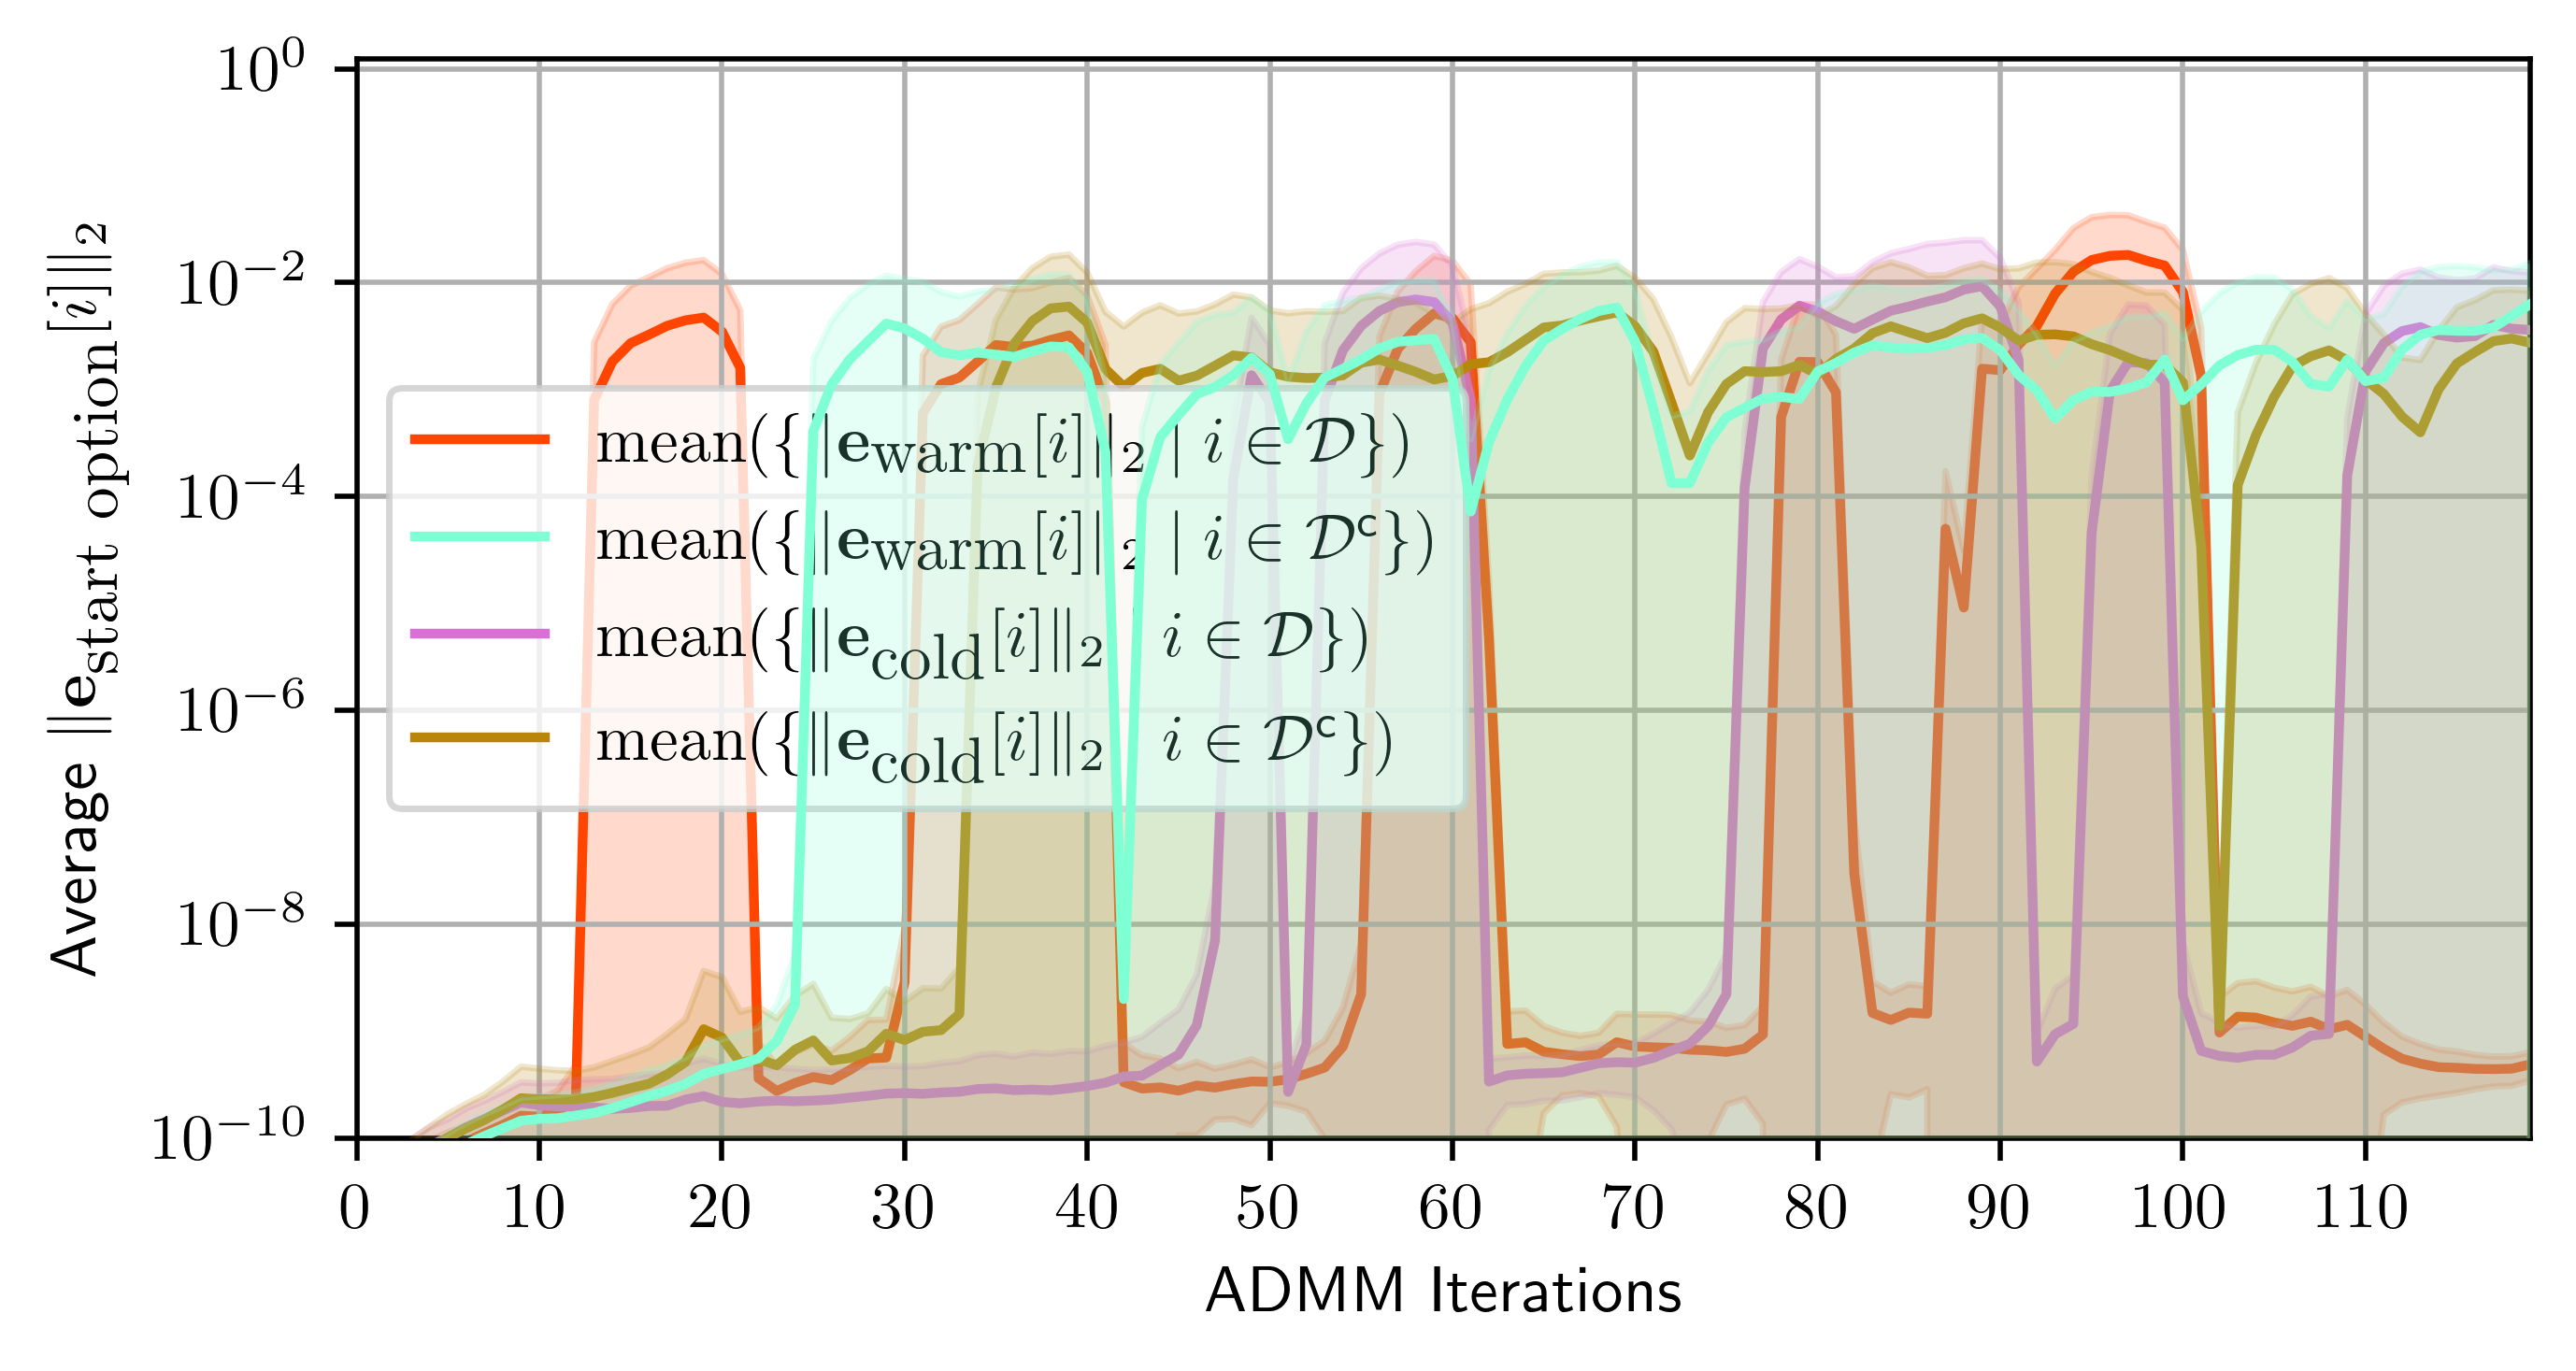

In [19]:
###     Plotting            - Error Convergence

save_err = False
rho = rho_opt[1]
sigma_scale = 1
plt.rcParams.update({
                    'text.usetex': True,
                    })


# Average Agents - WARM START
results_warm = results_dict[(rho, warm_start_opt[0])]
x_norm_warm = results_warm[-1]['x_norm_history']
x_norm_warm = [x_norm_warm[i].flatten() for i in range(num_agents)]
x_norm_warm_nominal = np.zeros((n_iter, 3))
x_norm_warm_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_warm[id][iter])
        else: 
            nominal_vals.append(x_norm_warm[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_warm_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_warm_nominal[iter, 1] = nominal_mean
    x_norm_warm_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_warm_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_warm_faulty[iter, 1] = faulty_mean
    x_norm_warm_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Average Agents - COLD START
results_cold = results_dict[(rho, warm_start_opt[1])]
x_norm_cold = results_cold[-1]['x_norm_history']
x_norm_cold = [x_norm_cold[i].flatten() for i in range(num_agents)]
x_norm_cold_nominal = np.zeros((n_iter, 3))
x_norm_cold_faulty = np.zeros((n_iter, 3))

for iter in range(n_iter):

    nominal_vals = []
    faulty_vals = []
    for id in range(num_agents):

        if id in faulty_id:
            faulty_vals.append(x_norm_cold[id][iter])
        else: 
            nominal_vals.append(x_norm_cold[id][iter])
    
    nominal_stdev = stdev(nominal_vals)
    nominal_mean = mean(nominal_vals)
    x_norm_cold_nominal[iter, 0] = nominal_mean - sigma_scale*nominal_stdev
    x_norm_cold_nominal[iter, 1] = nominal_mean
    x_norm_cold_nominal[iter, 2] = nominal_mean + sigma_scale*nominal_stdev

    faulty_stdev = stdev(faulty_vals)
    faulty_mean = mean(faulty_vals)
    x_norm_cold_faulty[iter, 0] = faulty_mean - sigma_scale*faulty_stdev
    x_norm_cold_faulty[iter, 1] = faulty_mean
    x_norm_cold_faulty[iter, 2] = faulty_mean + sigma_scale*faulty_stdev


# Create Figure
fig_err1 = plt.figure(dpi=500, figsize=(6,3))
ax_err1 = fig_err1.add_subplot()
lines = [None] * 4
areas = [None] * 4


# Warm Start, Faulty
ax_err1.fill_between(np.arange(n_iter), x_norm_warm_faulty[:, 0], x_norm_warm_faulty[:, 2],
                    alpha=0.2, color='orangered', zorder=0)
lines[0] = ax_err1.plot(np.arange(n_iter), x_norm_warm_faulty[:, 1],
                       c='orangered', zorder=1,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{warm}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Warm Start, Nominal
ax_err1.fill_between(np.arange(n_iter), x_norm_warm_nominal[:, 0], x_norm_warm_nominal[:, 2],
                    alpha=0.2, color='aquamarine', zorder=7)
lines[1] = ax_err1.plot(np.arange(n_iter), x_norm_warm_nominal[:, 1],
                       c='aquamarine', zorder=6, 
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{warm}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')

# Cold Start, Faulty
ax_err1.fill_between(np.arange(n_iter), x_norm_cold_faulty[:, 0], x_norm_cold_faulty[:, 2],
                    alpha=0.2, color='orchid', zorder=2)
lines[2] = ax_err1.plot(np.arange(n_iter), x_norm_cold_faulty[:, 1],
                       c='orchid', zorder=3,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{cold}[i] \|_2 \mid i \in \mathcal{D} \} )$')

# Cold Start, Nominal
ax_err1.fill_between(np.arange(n_iter), x_norm_cold_nominal[:, 0], x_norm_cold_nominal[:, 2],
                    alpha=0.2, color='darkgoldenrod', zorder=4)
lines[3] = ax_err1.plot(np.arange(n_iter), x_norm_cold_nominal[:, 1],
                       c='darkgoldenrod', zorder=5,
                       label=r'$\textnormal{mean}( \{ \| \mathbf{e}_\textnormal{cold}[i] \|_2 \mid i \in \mathcal{D}^\mathsf{c} \} )$')


# Figure Settings
ax_err1.set_xlabel(r'ADMM Iterations')
ax_err1.set_ylabel(r'Average $\| \mathbf{e}_\textnormal{start option}[i] \|_2 $')
# ax_err1.set_ylabel(r'$ \| \mathbf{x}[i] - ( \mathbf{x}^* [i] + \hat{\mathbf{x}}[i]) \| $')
ax_err1.set_ylim((1e-10, 1.25))
ax_err1.set_xlim((0, (n_iter - 1)))
ax_err1.set_xticks(ticks=np.arange(0, n_iter, n_admm))
# ax_err1.set_yticks(ticks=np.arange(0, 1.25, 0.25))
ax_err1.set_yscale('log')
ax_err1.legend()
ax_err1.grid(True)


# Save Figure
dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
fname_err = "final_fig/discrete/low/compare_err_conv-low_noise-" + dt_string + ".svg"
if save_err:
    plt.savefig(fname_err, dpi=500)